## CAPM Simulation_South Africa

In [193]:
## To evaluate the samll sample properties of the IV method, a battery of simulations are conducted using the parameters
## matched to real data.

In [454]:
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.gmm import IV2SLS
import linearmodels

In [455]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [456]:
df_MR = pd.read_csv('df_MR.csv')

In [457]:
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])

In [458]:
df_MR.set_index('Dates',inplace=True)

In [459]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

In [460]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR.dropna(axis = 0, how = 'all')

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.000000,-0.026116,NaN,-0.070618,NaN,NaN,-0.013234,NaN,-0.016129,NaN,...,0.000000,NaN,0.0,NaN,NaN,-0.109199,NaN,NaN,-0.104700,0.000000
2000-01-06,-0.080043,0.000000,NaN,-0.024693,NaN,NaN,0.034932,NaN,-0.033061,NaN,...,0.081967,NaN,0.0,NaN,NaN,-0.039221,NaN,NaN,0.000000,0.000000
2000-01-07,0.117783,-0.005900,NaN,0.048790,NaN,NaN,0.094951,NaN,-0.042925,NaN,...,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,-0.028988,0.000000
2000-01-10,0.068993,0.015656,NaN,0.000000,NaN,NaN,0.043488,NaN,0.074108,NaN,...,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.084557,0.029559
2000-01-11,-0.068993,0.000000,NaN,-0.048790,NaN,NaN,-0.088186,NaN,0.037740,NaN,...,0.081967,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-12-26,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-12-27,0.000000,0.000000,0.0,0.000000,0.0,0.0,-0.080043,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.016737,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [461]:
df_Ex_SR = df_SR-df_RF.values

In [462]:
df_Ex_SR = df_Ex_SR.loc[df_MR.index,:]

In [463]:
ols_model = LinearRegression()

In [464]:
## For each stock, we fit market model regressions to esimate constant betas and residual return standard deviation;
## Then we match the simulation paramters (mean&std_dev) to the distribution of these parametes in the real data.

In [472]:
## Constant beta estimations without rolling windows
all_betas = []
all_sigmas = []

betas = []
sigmas = []
labels = []
# j is cross-sectional stock name
for j in tqdm(df_Ex_SR.columns):
    df_index = df_Ex_SR.loc[:,j].dropna().index

    if len(df_index) != 10:
#         lag = int(4*((len(df_Ex_SR.loc[df_index,j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR.loc[df_index,j].values.astype(np.float64), sm.add_constant(df_MR.loc[df_index,:].values.astype(np.float64)))
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        res = ols.fit()
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)
        sigmas.append(s)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_sigmas.append(pd.DataFrame(sigmas))


100%|██████████| 740/740 [00:01<00:00, 460.22it/s]


In [473]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas = df_betas[(np.abs((df_betas-df_betas.mean())/df_betas.std()) <= 3).all(axis=1)]
df_betas

,Intercepts,MKT
Stocks,,
ABC.SJ.Equity,-0.000527,0.012906
ABI.SJ.Equity,-0.000128,0.065382
ABK.SJ.Equity,-0.001182,0.182993
ABR.SJ.Equity,-0.001066,-0.022444
ABU.SJ.Equity,-0.000235,0.010576
...,...,...
ZPT.SJ.Equity,-0.001798,0.079832
ZRNHDG.SJ.Equity,-0.000197,0.012835
ZRNPLY.SJ.Equity,-0.000181,0.000153


In [474]:
## The following is residual return standard deviations
df_sigmas = pd.concat([all_sigmas[0], pd.DataFrame(labels)], axis = 1)
df_sigmas.columns = ['sigmas','Stocks']
df_sigmas = df_sigmas.set_index('Stocks')
df_sigmas = df_sigmas[(np.abs((df_sigmas-df_sigmas.mean())/df_sigmas.std()) <= 3).all(axis=1)]
df_sigmas

,sigmas
Stocks,
ABC.SJ.Equity,0.019822
ABI.SJ.Equity,0.005701
ABK.SJ.Equity,0.044608
ABR.SJ.Equity,0.025737
ABU.SJ.Equity,0.008763
...,...
ZPT.SJ.Equity,0.065835
ZRNHDG.SJ.Equity,0.002140
ZRNPLY.SJ.Equity,0.000040


In [475]:
## We conduct simulations with the cross-sectional size of N=819 stocks. We randomly generat daily returns using the following procedures:
## Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.

In [476]:
## ** the mean and standard deviation of simulated beta/residuals the same as the real betas'/residuals' 
m_all_betas = np.mean(df_betas.iloc[:,1])
sd_all_betas = np.std(df_betas.iloc[:,1])
print(m_all_betas, sd_all_betas)

0.16514471061904212 0.21161089569068053


In [477]:
## ** the mean and standard deviation of simulated beta/residuals the same as the real betas'/residuals' 
m_all_sigmas = np.mean(df_sigmas.iloc[:,0].astype('float64'))
sd_all_sigmas = np.std(df_sigmas.iloc[:,0].astype('float64'))
print(m_all_sigmas, sd_all_sigmas)

0.01840973708300509 0.013629287305736423


In [478]:
print(m_all_sigmas*252*100, sd_all_sigmas*np.sqrt(252)*100)

463.92537449172823 21.635822854816876


## beta,i and res_sigma,i are fixed through 100 repetitions

In [449]:
# How many stocks in the simulation sample on cross-sectional scale
N = 500

In [450]:
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
np.mean(sim_betas_tmp), np.std(sim_betas_tmp)

(0.18828144521225876, 0.21214115076913997)

In [451]:
sim_betas = pd.DataFrame(sim_betas_tmp)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.43069,-0.365938,0.404091,0.473644,-0.102391,0.34849,0.720341,0.161776,0.166774,0.198424,...,0.271684,0.389562,0.223878,0.186778,0.3873,0.293347,-0.374777,0.113996,0.131347,0.392684


In [452]:
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.018650090886684855, 0.013314833730293352)

In [453]:
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.017144,0.014963,0.030089,0.036859,0.010869,0.015121,0.005711,0.006788,0.024829,0.019225,...,0.017761,0.027257,0.010936,0.019265,0.014707,0.005039,0.032048,0.009393,0.01683,0.027161


In [215]:
## Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation
## equal to the sample mean and standard deviation from the data

## sim_MKT, sim_SR and res_return are changable through 100 repetitions

In [405]:
mean_MKT = np.mean(df_MR.iloc[:,0])
sd_MKT = np.std(df_MR.iloc[:,0])
print(mean_MKT, sd_MKT)

0.0002807670182166827 0.011549088535812713


In [406]:
print(mean_MKT*252*100, sd_MKT*np.sqrt(252)*100)

7.075328859060404 18.33360968113651


In [217]:
## It's important to make sure that np.mean(sim_MKT_tmp) is precisely equal to mean_MKT, otherwise the gap between 
## ex-ante and ex-post biases will be significant

In [218]:
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= len(df_MR)))
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

0.0005881940910184678 0.011587003954633777


In [219]:
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = df_MR.index
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
Dates,
2000-01-05,0.000205
2000-01-06,0.021313
2000-01-07,0.023786
2000-01-10,-0.019477
2000-01-11,0.005164
...,...
2019-12-25,0.007174
2019-12-26,-0.012277
2019-12-27,-0.012295


In [220]:
## Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and
## standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [221]:
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
# d = pd.DataFrame(np.zeros((N_rows, N_cols)))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.041043,0.006152,-0.003368,0.012065,0.014403,-0.003608,0.001945,0.011993,0.001746,-0.002385,...,-0.027312,0.003398,0.041448,0.001641,-0.026601,0.000920,-0.006880,0.014617,0.010906,0.012907
1,0.022632,-0.000116,0.002863,0.008138,0.009593,0.013472,0.003359,0.008187,-0.007244,-0.004529,...,0.009002,-0.001971,-0.009344,-0.025842,0.007329,0.004718,-0.009700,-0.027224,0.006094,0.020600
2,-0.009492,0.020567,-0.004019,0.035356,-0.007657,-0.011697,-0.003826,0.012679,0.016998,0.007466,...,0.024797,0.002692,0.020746,-0.015914,-0.011237,-0.021540,0.000073,-0.013486,-0.008890,0.038681
3,-0.020733,-0.000360,0.011079,-0.030362,-0.001177,-0.005426,-0.002990,0.013984,0.013512,0.006378,...,-0.057559,-0.001631,-0.017066,-0.019252,-0.016489,-0.043802,-0.016740,0.015360,0.006825,-0.043834
4,0.002973,-0.005457,-0.001666,0.004283,-0.006777,0.007497,-0.004555,-0.002357,0.004007,-0.001900,...,-0.029606,-0.002348,0.016938,0.046284,0.007982,0.028519,0.005670,0.015795,0.015447,-0.012981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5210,-0.039764,0.006580,-0.004341,0.001576,-0.003787,0.026211,0.000890,0.022494,-0.006277,0.000080,...,-0.010808,-0.002830,0.031368,-0.047049,-0.023564,-0.015387,0.005107,0.015463,-0.028776,0.069823
5211,0.021790,0.013747,-0.007087,0.002520,-0.009029,0.024255,0.002584,0.001280,-0.000660,-0.000734,...,0.047569,0.006717,0.050025,0.067002,-0.034014,0.044228,0.014298,0.001934,-0.033209,-0.037868
5212,0.018783,0.010102,0.008487,0.020074,-0.003691,-0.105999,0.002853,-0.001481,-0.012839,-0.001085,...,-0.006724,0.002287,-0.017297,0.005199,0.005931,0.048456,0.007770,0.008185,-0.008786,-0.019201
5213,-0.049449,-0.000417,0.000920,-0.018009,0.005814,-0.080403,-0.001526,-0.002593,-0.000398,0.000080,...,0.014244,0.001304,0.000661,-0.040206,0.002040,-0.008300,0.020780,0.014120,-0.025648,0.008838


In [222]:
## Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t

In [223]:
sim_SR = (np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = df_Ex_SR.index
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.041066,0.006200,-0.003353,0.012032,0.014404,-0.003634,0.001999,0.011941,0.001738,-0.002360,...,-0.027274,0.003445,0.041560,0.001660,-0.026609,0.000960,-0.006863,0.014687,0.010937,0.012990
2000-01-06,0.024979,0.004908,0.004427,0.004772,0.009722,0.010767,0.009020,0.002704,-0.008077,-0.001956,...,0.012915,0.002913,0.002284,-0.023830,0.006433,0.008947,-0.007949,-0.019984,0.009364,0.029211
2000-01-07,-0.006873,0.026174,-0.002273,0.031599,-0.007513,-0.014716,0.002492,0.006560,0.016068,0.010338,...,0.029165,0.008143,0.033724,-0.013668,-0.012237,-0.016819,0.002028,-0.005405,-0.005241,0.048292
2000-01-10,-0.022877,-0.004951,0.009649,-0.027286,-0.001295,-0.002953,-0.008163,0.018995,0.014273,0.004026,...,-0.061135,-0.006094,-0.027693,-0.021091,-0.015670,-0.047667,-0.018341,0.008744,0.003837,-0.051703
2000-01-11,0.003541,-0.004240,-0.001287,0.003467,-0.006746,0.006841,-0.003183,-0.003685,0.003805,-0.001277,...,-0.028658,-0.001165,0.019755,0.046772,0.007765,0.029543,0.006094,0.017549,0.016239,-0.010894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,-0.038974,0.008271,-0.003814,0.000443,-0.003744,0.025300,0.002796,0.020649,-0.006558,0.000946,...,-0.009490,-0.001186,0.035282,-0.046372,-0.023866,-0.013964,0.005697,0.017901,-0.027675,0.072722
2019-12-26,0.020438,0.010853,-0.007989,0.004459,-0.009103,0.025814,-0.000678,0.004438,-0.000180,-0.002216,...,0.045314,0.003904,0.043327,0.065843,-0.033498,0.041792,0.013289,-0.002237,-0.035092,-0.042829
2019-12-27,0.017429,0.007203,0.007584,0.022016,-0.003765,-0.104438,-0.000413,0.001682,-0.012358,-0.002570,...,-0.008982,-0.000531,-0.024005,0.004038,0.006447,0.046016,0.006759,0.004008,-0.010672,-0.024169


In [224]:
from datetime import datetime
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods):
    m = mons[i]
    months.append(np.repeat(m,21))

In [225]:
## sum daily stock and factor log returns to compute corresponding monthly returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:-1,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
month,,,,,,,,,,,,,,,,,,,,,
2000-01,-0.027635,0.013125,-0.001808,-0.041711,0.073136,0.020373,0.013432,-0.039262,0.047677,-0.003317,...,-0.520385,0.034957,0.215425,0.048970,-0.031181,0.083167,-0.044937,0.121182,-0.029545,0.208235
2000-02,-0.462700,0.013979,0.018513,0.087600,-0.073346,0.177860,0.000048,0.094275,0.065285,0.002180,...,-0.211357,-0.008725,0.381516,-0.205130,-0.097941,0.054954,0.071768,-0.026051,0.036649,0.061952
2000-03,-0.020440,0.014158,0.043966,-0.122834,0.076225,-0.056522,-0.022044,0.106144,-0.030378,0.018581,...,-0.082463,-0.006391,0.067868,-0.147941,-0.120182,0.143859,-0.067815,0.045479,-0.056055,0.033257
2000-04,0.080566,-0.038017,0.007773,0.006839,0.030001,-0.204198,-0.001207,-0.005289,0.001442,-0.021275,...,-0.151677,-0.021566,0.105433,0.008727,0.137932,-0.084843,-0.065734,0.045616,0.050836,-0.167442
2000-05,0.271398,0.036559,-0.020988,0.023210,0.077483,-0.070238,0.023963,0.091320,-0.021768,0.007164,...,-0.144181,-0.022551,0.253158,-0.280189,0.081203,0.093609,-0.041766,0.091689,0.023735,0.000662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04,-0.131957,-0.052141,0.019332,0.012283,0.068282,0.144445,0.033728,0.015097,-0.032657,-0.010054,...,0.038858,0.013480,-0.104126,0.055047,-0.012075,-0.061146,0.057384,0.047460,-0.068681,0.285717
2020-05,-0.057958,-0.013612,-0.041765,-0.007927,0.070456,-0.017751,0.000073,0.009511,-0.009842,0.009234,...,-0.125737,0.009639,-0.038174,-0.075136,0.039486,-0.003911,0.115328,-0.003312,-0.105318,0.080353
2020-06,0.055101,-0.022186,0.018386,0.007759,0.053979,-0.037202,0.005976,-0.033262,0.063502,0.010500,...,0.056969,0.026675,-0.014106,-0.095022,0.095563,0.020308,0.051958,0.040489,0.123932,0.001892


In [226]:
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:-1,:]
m_sim_MKT

,RM-RF
month,
2000-01,0.096521
2000-02,-0.027479
2000-03,-0.077969
2000-04,-0.012170
2000-05,0.054636
...,...
2020-04,0.047726
2020-05,-0.028517
2020-06,0.025044


In [227]:
## Step-5: For the first-stage regression in the simulation, we estimate betas using time series regression (OLS&IV)

### OLS (without rolling window)

In [228]:
# use the factor model in linearmodel module, however, this function would not allow for time-varying beta meaning that
# the result of this FM two-step regression would be the same as cross-sectional regression.
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                500   R-squared:                      0.0187
No. Factors:                          1   J-statistic:                    568.02
No. Observations:                  5215   P-value                         0.0173
Date:                  Mon, Apr 11 2022   Distribution:                chi2(499)
Time:                          16:43:36                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF          0.0007     0.0002     3.8799     0.0001      0.0003      0.0010
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [229]:
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-np.mean(sim_MKT))/np.mean(sim_MKT)*100).values))

ex-ante bias(%):[132.67163959]
ex-post bias(%):[11.06286763]


In [230]:
# from linearmodels.asset_pricing import LinearFactorModelGMM
# model_GMM = LinearFactorModelGMM(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
# res_GMM = model_GMM.fit()
# res_GMM

In [370]:
all_betas_test = pd.DataFrame()
all_resids = pd.DataFrame()

# i is time in periods
for j in tqdm(sim_SR.columns):
    
    betas = []
    # j is cross-sectional stock name
#     lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
    ols = sm.OLS(sim_SR.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT.values.astype(np.float64)))
    res = ols.fit()
#     res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
    b = list(res.params)
    r = list(res.resid)
    betas.append(b)
    
    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercept', 1:'MKT'})
    all_betas_test = pd.concat([all_betas_test, df_betas], axis = 0)
    all_resids = pd.concat([all_resids, pd.DataFrame(r)], axis = 1)

100%|██████████| 500/500 [00:05<00:00, 96.30it/s] 


In [371]:
all_betas_test = all_betas_test.reset_index(drop=True)
all_betas_test 

,Intercept,MKT
0,0.000621,0.132290
1,-0.000082,0.250951
2,0.000106,0.047171
3,-0.000446,-0.154290
4,-0.000067,-0.002511
...,...,...
495,0.000624,0.153756
496,-0.000104,0.061876
497,-0.000031,0.313634
498,0.000392,0.177956


In [331]:
alphas = pd.DataFrame(all_betas_test.Intercept).T
alphas = pd.concat([alphas]*len(sim_SR), axis = 0).reset_index(drop=True)
alphas.index = sim_SR.index
alphas.columns = sim_SR.columns
alphas.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.000621,-0.000082,0.000106,-0.000446,-0.000067,-0.000045,-0.000027,0.000087,-0.000178,0.000041,...,-0.000102,-0.000002,0.000361,0.000255,-0.000062,0.000624,-0.000104,-0.000031,0.000392,-0.000575
2000-01-06,0.000621,-0.000082,0.000106,-0.000446,-0.000067,-0.000045,-0.000027,0.000087,-0.000178,0.000041,...,-0.000102,-0.000002,0.000361,0.000255,-0.000062,0.000624,-0.000104,-0.000031,0.000392,-0.000575
2000-01-07,0.000621,-0.000082,0.000106,-0.000446,-0.000067,-0.000045,-0.000027,0.000087,-0.000178,0.000041,...,-0.000102,-0.000002,0.000361,0.000255,-0.000062,0.000624,-0.000104,-0.000031,0.000392,-0.000575
2000-01-10,0.000621,-0.000082,0.000106,-0.000446,-0.000067,-0.000045,-0.000027,0.000087,-0.000178,0.000041,...,-0.000102,-0.000002,0.000361,0.000255,-0.000062,0.000624,-0.000104,-0.000031,0.000392,-0.000575
2000-01-11,0.000621,-0.000082,0.000106,-0.000446,-0.000067,-0.000045,-0.000027,0.000087,-0.000178,0.000041,...,-0.000102,-0.000002,0.000361,0.000255,-0.000062,0.000624,-0.000104,-0.000031,0.000392,-0.000575


In [329]:
pred_SR = pd.DataFrame(np.dot(sim_MKT, np.mat(all_betas_test.MKT.T)), columns=sim_SR.columns, index = sim_SR.index) + alphas
resids = sim_SR - (pred_SR)
resids.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.040417,0.006230,-0.003469,0.012510,0.014472,-0.003551,0.001972,0.011900,0.001920,-0.002425,...,-0.027221,0.003402,0.041089,0.001372,-0.026549,0.000305,-0.006771,0.014653,0.010509,0.013474
2000-01-06,0.021538,-0.000359,0.003316,0.008506,0.009843,0.014764,0.003447,0.007360,-0.007464,-0.004491,...,0.007919,-0.001754,-0.009531,-0.027465,0.006288,0.005046,-0.009163,-0.026637,0.005179,0.020369
2000-01-07,-0.010641,0.020287,-0.003501,0.035716,-0.007386,-0.010261,-0.003731,0.011767,0.016732,0.007513,...,0.023577,0.002934,0.020580,-0.017695,-0.012406,-0.021101,0.000660,-0.012835,-0.009865,0.038357
2000-01-10,-0.020922,0.000018,0.010462,-0.029844,-0.001276,-0.006520,-0.003019,0.014574,0.014053,0.006265,...,-0.056374,-0.001825,-0.017586,-0.018258,-0.015419,-0.045296,-0.017032,0.014883,0.006911,-0.042522
2000-01-11,0.002237,-0.005454,-0.001636,0.004710,-0.006665,0.007844,-0.004513,-0.002623,0.004089,-0.001922,...,-0.029791,-0.002294,0.016620,0.045698,0.007777,0.028126,0.005879,0.015960,0.014928,-0.012601


In [330]:
all_resids.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.040417,0.006230,-0.003469,0.012510,0.014472,-0.003551,0.001972,0.011900,0.001920,-0.002425,...,-0.027221,0.003402,0.041089,0.001372,-0.026549,0.000305,-0.006771,0.014653,0.010509,0.013474
1,0.021538,-0.000359,0.003316,0.008506,0.009843,0.014764,0.003447,0.007360,-0.007464,-0.004491,...,0.007919,-0.001754,-0.009531,-0.027465,0.006288,0.005046,-0.009163,-0.026637,0.005179,0.020369
2,-0.010641,0.020287,-0.003501,0.035716,-0.007386,-0.010261,-0.003731,0.011767,0.016732,0.007513,...,0.023577,0.002934,0.020580,-0.017695,-0.012406,-0.021101,0.000660,-0.012835,-0.009865,0.038357
3,-0.020922,0.000018,0.010462,-0.029844,-0.001276,-0.006520,-0.003019,0.014574,0.014053,0.006265,...,-0.056374,-0.001825,-0.017586,-0.018258,-0.015419,-0.045296,-0.017032,0.014883,0.006911,-0.042522
4,0.002237,-0.005454,-0.001636,0.004710,-0.006665,0.007844,-0.004513,-0.002623,0.004089,-0.001922,...,-0.029791,-0.002294,0.016620,0.045698,0.007777,0.028126,0.005879,0.015960,0.014928,-0.012601


In [321]:
corr_x_res = []

for j in tqdm(range(len(resids.columns))):
    corr = stats.pearsonr(sim_MKT.values.flatten(), resids.iloc[:,j].values)
    corr_x_res.append(corr)

100%|██████████| 500/500 [00:00<00:00, 4653.41it/s]


In [322]:
pd.DataFrame(corr_x_res).head()

,0,1
0,6.418477e-17,1.0
1,-3.747003e-16,1.0
2,-9.540979e-17,1.0
3,3.209238e-16,1.0
4,1.734723e-18,1.0


In [324]:
from statsmodels.graphics.tsaplots import plot_acf

Asset_Number = 321


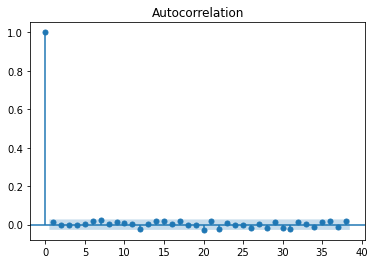

In [363]:
k = np.random.randint(0,len(sim_SR.columns))
plot_acf(resids.iloc[:,k])
print('Asset_Number = ' + str(k))
plt.show()

In [326]:
from statsmodels.stats.stattools import durbin_watson

In [364]:
## The null hypothesis of the test is that there is no serial correlation in the residuals.
all_dws = []

for j in range(len(resids.columns)):
    dw = durbin_watson(resids.iloc[:,j])
    all_dws.append(dw)

print(np.mean(all_dws))

2.001420141063041


In [374]:
beta_err = sim_betas - all_betas_test.MKT

In [382]:
durbin_watson(beta_err.T)

array([2.06067084])

In [388]:
lamdas = []

for i in tqdm(range(len(sim_SR))):
    ols = sm.OLS(sim_SR.iloc[i,:], sim_betas.T)
    res = ols.fit()
    l = list(res.params)
    lamdas.append(l)

100%|██████████| 5215/5215 [00:04<00:00, 1164.02it/s]


In [395]:
print(np.mean(lamdas), mean_MKT)

0.0006586068284500402 0.0002807670182166827


## OLS (Time-varying Betas)

In [39]:
# how many years in the rolling window periods
n = 5

In [40]:
holding = 21 # 1 month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

187 1260


In [41]:
all_betas = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is cross-sectional stock name
    for j in sim_SR.columns:      
#         lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT_tmp.values.astype(np.float64)))
        res = OLS.fit()
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        b = list(res.params)
        betas.append(b)

    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)

100%|██████████| 187/187 [00:31<00:00,  6.00it/s]


In [42]:
all_betas[0]

,Intercepts,MKT
0,0.000502,0.105686
1,0.000050,0.280009
2,-0.000270,0.166288
3,0.000025,0.559503
4,0.002935,0.415111
...,...,...
495,-0.000665,-0.163544
496,-0.000016,0.023639
497,0.000163,0.023739
498,-0.000433,0.131471


In [43]:
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.9705705168090117 4539.850344382344


In [44]:
holding = 1 # 1 month
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

187 60


In [45]:
# sum daily market return to compute corresponding monthly returns
m_MR = df_MR
m_MR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_MR = m_MR.groupby('month').sum()
df_MR = df_MR.drop(['month'], axis = 1)
m_MR = m_MR.iloc[:-1,:]
m_MR

,MR_RF
month,
2000-01,0.0154
2000-02,-0.0955
2000-03,-0.0024
2000-04,-0.0693
2000-05,-0.0119
...,...
2020-04,-0.0695
2020-05,0.0382
2020-06,-0.0010


In [46]:
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 187/187 [00:00<00:00, 717.11it/s]


In [47]:
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.004763,-0.055602
1,-0.000237,0.134894
2,0.002189,-0.028186
3,0.005602,-0.083927
4,-0.003691,0.022683
...,...,...
182,-0.003862,0.016897
183,0.002291,-0.108415
184,-0.008434,0.069451
185,0.006197,-0.010692


In [48]:
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.069250,0.061008,-0.125383,0.085756,-0.021324,0.017514,0.104837,-0.039175,-0.056793,-0.073887,...,0.002402,-0.070955,-0.122932,0.083060,-0.179191,0.040268,-0.026797,-0.204149,0.079408,0.062417
1,0.012035,-0.163485,0.006702,-0.079732,0.092549,-0.003761,-0.020256,-0.031122,-0.011478,-0.079123,...,0.102014,0.017225,0.025536,0.046180,0.006776,0.062038,0.010475,0.009960,0.023706,-0.112475
2,-0.018637,0.005144,-0.012950,-0.006642,-0.008904,0.009640,-0.001154,-0.000794,-0.015868,0.038412,...,0.036124,0.014744,-0.003239,-0.001226,-0.024894,-0.006243,-0.018543,-0.004496,-0.009066,-0.041215
3,-0.000761,-0.025825,-0.003299,-0.022081,-0.001737,0.002112,0.029222,-0.009931,0.004461,0.009735,...,0.023107,0.016559,-0.003643,-0.001626,0.016447,-0.011075,-0.003746,-0.019607,0.011504,-0.019974
4,0.239278,0.267693,0.124245,0.030555,-0.066119,0.065047,-0.184400,-0.306213,-0.179123,0.225060,...,0.049467,-0.027770,-0.017915,0.027128,-0.388291,-0.016035,0.066688,-0.165819,0.137903,0.003572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.249527,0.110969,0.018864,0.138597,0.196834,0.171769,0.051217,-0.068638,0.169105,0.048978,...,0.010379,-0.018556,-0.190492,0.043086,-0.121266,0.040797,0.138437,0.101553,-0.006440,-0.006255
496,-0.015661,0.036297,-0.013987,0.004369,0.030038,-0.001299,-0.007728,-0.003040,-0.030132,-0.026422,...,-0.017371,-0.037277,0.020242,0.008081,0.034188,-0.009214,-0.015307,0.016187,0.003085,0.004125
497,0.043149,0.004021,-0.042456,-0.043556,0.090534,0.014925,-0.047119,-0.056050,0.024928,-0.030083,...,-0.043239,-0.040567,-0.066311,-0.035285,0.068180,-0.068826,0.024348,0.015272,-0.058627,0.009210
498,0.050442,0.125917,0.072767,0.091295,0.005414,0.033162,0.046895,0.041430,0.005447,0.020010,...,-0.217075,-0.082896,-0.125394,0.139014,-0.001386,0.109048,-0.015222,-0.026023,0.100722,0.016050


In [49]:
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)

Ttest_1sampResult(statistic=array([1.02842802, 1.21236985]), pvalue=array([0.30508406, 0.22690853]))

In [50]:
## ***Risk Premium estimate for one simulation
np.mean(all_lambdas_OLS[0].iloc[:,1]) # simulation market premium
## ***Corresponding true simulation parameters, 0.0002807670182166827 is our true daily market risk premium, i.e. 0.07075328859060404 per annum
np.mean(m_MR) #true market premium
print(np.mean(m_MR.values), np.mean(all_lambdas_OLS[0].iloc[:,1]))

0.005930241935483869 0.004792413790548377


In [51]:
# Test whether the betas in FM-2 is endougenous

In [52]:
corr_betas_res = []

for i in range(np.shape(all_resids_OLS)[1]):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),all_resids_OLS.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_res.append(corr)

print(np.mean(corr_betas_res), "x is Endogenous" if np.mean(corr_betas_res).round(10)!=0 else "x is Exogenous")

-4.800638496352929e-19 x is Exogenous


In [53]:
m_MR_tmp = m_MR.iloc[rollingW+1:len(m_MR),:]
m_sim_MKT_tmp = m_sim_MKT.iloc[rollingW+1:len(m_MR),:]

In [54]:
print(np.mean(m_MR.values),np.mean(all_lambdas_OLS[0].iloc[:,1].values))

0.005930241935483869 0.004792413790548381


In [55]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))

ex-ante bias(%): -19.186875633643986
ex-post bias(%): -48.79065904591853


In [56]:
## The Ex-ante RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.07576035160752409

In [57]:
## The Ex-post RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.07913468623527901

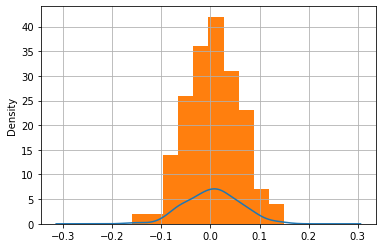

In [58]:
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

## IV(Time-varying Betas)

In [59]:
holding = 21
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

1260 187


In [60]:
all_betas_ev = []
all_betas_iv = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is cross-sectional stock label
        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)
        
        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

100%|██████████| 187/187 [01:52<00:00,  1.67it/s]


In [61]:
all_betas_ev[0]

,0
0,0.103456
1,0.194676
2,0.178702
3,0.558629
4,0.490429
...,...
495,-0.149155
496,0.012277
497,-0.014340
498,0.123068


In [62]:
all_betas_iv[0]

,0
0,0.117556
1,0.378453
2,0.150712
3,0.560517
4,0.326918
...,...
495,-0.183505
496,0.036437
497,0.068548
498,0.143363


In [63]:
## Calculating the estimated lambdas

In [64]:
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

187 60


In [65]:
# A rule of thumb is the first stage (i.e., the regression of x on the instrument and any covariates)
# should have an F statistic of at least 10.

fvalues = []

for i in tqdm(range(len(all_betas_ev))):
    ols = sm.OLS(all_betas_ev[i].values.astype(np.float64), sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
    res = ols.fit()
    f = res.fvalue
    fvalues.append(f)


100%|██████████| 187/187 [00:00<00:00, 3654.72it/s]


In [66]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     2016.
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          3.34e-177
Time:                        00:44:04   Log-Likelihood:                 457.47
No. Observations:                 500   AIC:                            -910.9
Df Residuals:                     498   BIC:                            -902.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0162      0.005      3.211      0.001       0.006       0.026
x1             0.8848      0.020     44.899      0.000       0.846       0.924
==============================================================================
Omnibus:                       53.406   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.825
Skew:                          -0.135   Prob(JB):                     6.51e-72
Kurtosis:                       6.958   Cond. No.                         4.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
pd.DataFrame(fvalues).describe()

,0
count,187.000000
mean,1828.213279
std,254.928305
min,1390.944147
25%,1671.181581
50%,1781.624283
75%,1951.900801
max,2701.981056


In [68]:
from linearmodels.iv.model import IV2SLS
# from linearmodels.iv.model import IVGMM
all_lambdas_IV = []
all_resids_IV = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    iv = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = np.ones(len(m_sim_SR.T), dtype=np.uint8),\
                endog = all_betas_ev[i].values.astype(np.float64),\
                instruments = all_betas_iv[i].values.astype(np.float64))
    res = iv.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 187/187 [00:00<00:00, 253.27it/s]


In [69]:
res.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:              dependent   R-squared:                      0.0836
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0818
No. Observations:                 500   F-statistic:                    41.819
Date:                Mon, Apr 11 2022   P-value (F-stat)                0.0000
Time:                        00:44:05   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog          -0.0010     0.0052    -0.1895     0.8497     -0.0112      0.0092
endog         -0.1568     0.0242    -6.4668     0.0000     -0.2043     -0.1092
==============================================================================

Endogenous: endog
Instruments: instruments
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [70]:
res.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 1.2645
P-value: 0.2614
Distributed: F(1,497)
WaldTestStatistic, id: 0x7fa5b0c26280

In [71]:
# from statsmodels.sandbox.regression.gmm import IV2SLS

# all_lambdas_IV = []
# all_resids_IV = []
# # i is time

# m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

# lambdas = []
# resids = []
# index_times = list(m_sim_SR_tmp_T.columns)

# for k in tqdm(m_sim_SR_tmp_T.columns):
    
#     i = int(index_times.index(k) / holding)
    
#     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = sm.add_constant(all_betas_ev[i].values.astype(np.float64)),\
#                 instrument = sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
# #     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = all_betas_ev[i].values.astype(np.float64),instrument = all_betas_iv[i].values.astype(np.float))
#     res = iv.fit()
#     l = list(res.params)
#     r = list(res.resid)
#     lambdas.append(l)
#     resids.append(r)

# all_lambdas_IV.append(pd.DataFrame(lambdas))
# all_resids_IV.append(pd.DataFrame(resids))


In [72]:
# Use the IV estimator equation to calculate lambdas

In [73]:
lam = []
for i in range(periods):
    a = np.dot(np.array(all_betas_iv[i]).T,np.array(all_betas_ev[i]))
    b = np.dot(np.array(all_betas_iv[i]).T, np.array(m_sim_SR_tmp_T.iloc[:,i]))
    l = np.linalg.inv(a)*b
    lam.append(l)

In [74]:
print(np.mean(lam),stats.ttest_1samp(lam, 0.0)[0])

0.006413983755663795 [[1.58476935]]


In [75]:
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.068701,0.059484,-0.125204,0.087305,-0.022184,0.018342,0.104655,-0.035944,-0.057748,-0.073299,...,0.002761,-0.070938,-0.121060,0.083066,-0.179791,0.040928,-0.032830,-0.200457,0.079015,0.053225
1,0.007747,-0.152633,0.005240,-0.086440,0.093971,-0.006065,-0.018764,-0.038535,-0.009014,-0.081766,...,0.104084,0.015264,0.023430,0.045686,0.006978,0.061844,0.011645,0.008603,0.023812,-0.107251
2,-0.017645,0.003048,-0.012044,-0.005934,-0.009532,0.010235,-0.001212,0.000450,-0.016396,0.038667,...,0.036340,0.014940,-0.003731,-0.001586,-0.025069,-0.006125,-0.019228,-0.004090,-0.009169,-0.041753
3,0.003167,-0.028612,0.001623,-0.025269,-0.004604,0.003666,0.030760,-0.010412,0.003649,0.008563,...,0.026604,0.013486,-0.012031,-0.003166,0.017693,-0.011789,0.001021,-0.021349,0.011043,-0.016423
4,0.246783,0.254500,0.130594,0.034785,-0.070029,0.068291,-0.183864,-0.301955,-0.180766,0.224634,...,0.051473,-0.029207,-0.023187,0.025767,-0.388049,-0.015373,0.065019,-0.164235,0.137337,0.004107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.247459,0.109581,0.016647,0.143539,0.197830,0.171362,0.049858,-0.065633,0.169100,0.050064,...,0.008536,-0.015911,-0.185362,0.043653,-0.122922,0.041615,0.134608,0.101191,-0.005957,-0.004767
496,-0.017600,0.039020,-0.015880,0.004124,0.031161,-0.002175,-0.007997,-0.004036,-0.029451,-0.026415,...,-0.019474,-0.034792,0.022792,0.007922,0.033284,-0.008576,-0.019575,0.018588,0.002961,0.000118
497,0.039468,0.010587,-0.045283,-0.045668,0.092561,0.013044,-0.047177,-0.059567,0.026615,-0.030777,...,-0.046206,-0.036160,-0.063320,-0.036014,0.066738,-0.067722,0.017034,0.019394,-0.058982,0.000557
498,0.049739,0.128871,0.071839,0.089464,0.006661,0.031999,0.047093,0.039424,0.006045,0.019558,...,-0.216097,-0.082273,-0.125749,0.138232,-0.001495,0.109219,-0.016007,-0.025149,0.100579,0.014933


In [76]:
# # Plot the distrubtion of the residuals
# label = all_resids_IV.index
# index = all_resids_IV.columns

# # Get the shape of df_residuals
# shape = all_resids_IV.shape

# plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)

# for j in tqdm(range(shape[1])):
#     plt.plot(all_resids_IV.iloc[:,j],)  

# plt.title('The distrubtion of residuals')
# # plt.xticks(np.arange(min(label), max(label)+1, 12), fontsize = 6)
# plt.xticks([], [])
# plt.yticks(fontsize = 6)
# # plt.xlabel('Stock Labels', fontsize = 10)
# plt.ylabel('Residuals', fontsize = 10)
# plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5, axis='y')
# plt.tight_layout()
# plt.show()

In [77]:
## test whether beta_iv (instrumental variables) is exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print(np.mean(corr_iv_res), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

6.864681134881482e-18 IV is Exogenous


In [78]:
## test whether beta_ev (explanatory variables) is exogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print(np.mean(corr_ev_res), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


-0.005470316280242189 EV is Endogenous


In [79]:
## weak instrument variable test
## the following calculate the average cross-sectional correlations between odd- and even-month betas 

In [80]:
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print(np.mean(corr_ev_iv), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

0.8851322801882395 IV is Strong


In [81]:
## and also calculate the average cross-sectional correlations between estimated and true betas 

In [82]:
corr_ev_true = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_ev_true.append(corr)

print(np.mean(corr_ev_true), stats.ttest_1samp(corr_ev_true, 0.0)[0])

0.9445371084363878 2528.866169730013


In [83]:
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.006188,-0.065272
1,-0.001393,0.141799
2,0.003823,-0.039813
3,0.004756,-0.076685
4,-0.004674,0.029524
...,...,...
182,-0.004068,0.018382
183,0.003663,-0.118350
184,-0.008946,0.072888
185,0.006059,-0.009561


In [84]:
stats.ttest_1samp(all_lambdas_IV[0], 0.0)

Ttest_1sampResult(statistic=array([0.46155073, 1.43104724]), pvalue=array([0.64494286, 0.15409466]))

In [85]:
all_lambdas_IV[0].describe()

,0,1
count,187.000000,187.000000
mean,0.000165,0.006057
std,0.004896,0.057881
min,-0.014027,-0.164745
25%,-0.003350,-0.030024
50%,0.000704,0.008262
75%,0.003723,0.040456
max,0.014801,0.166810


In [86]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))   

ex-ante bias(%): 2.1406683606058845
ex-post bias(%): -35.275905338791674


In [87]:
## The Ex-ante RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.07866261304258393

In [88]:
## The Ex-post RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.08177985071542217

### OLS with beta_ev

In [89]:
from linearmodels.iv.model import IV2SLS

all_lambdas_ols = []
all_resids_ols = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    ols = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = pd.concat([pd.DataFrame(np.ones(len(m_sim_SR.T), dtype=np.uint8)).T, all_betas_ev[i].T], axis =0,ignore_index=True).T,\
                endog = None,\
                instruments = None)
    res = ols.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_ols.append(pd.DataFrame(lambdas))
all_resids_ols.append(pd.DataFrame(resids))

100%|██████████| 187/187 [00:00<00:00, 221.72it/s]


In [90]:
all_resids_ols = pd.DataFrame(all_resids_ols[0].T)
all_resids_ols

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.069348,0.059471,-0.125188,0.087665,-0.021784,0.018148,0.104482,-0.035994,-0.057456,-0.072991,...,0.003436,-0.071496,-0.124539,0.082347,-0.179293,0.040701,-0.030519,-0.201211,0.078623,0.054845
1,0.006648,-0.151585,0.003828,-0.085532,0.094981,-0.006631,-0.019267,-0.038595,-0.008665,-0.081495,...,0.101942,0.017036,0.027452,0.046517,0.006429,0.062094,0.009680,0.009245,0.024173,-0.108742
2,-0.018437,0.003787,-0.013041,-0.005416,-0.008956,0.009882,-0.001526,0.000418,-0.016208,0.038837,...,0.035877,0.015323,-0.002753,-0.001383,-0.025194,-0.006068,-0.019701,-0.003936,-0.009095,-0.042061
3,-0.004900,-0.021874,-0.007459,-0.020423,0.000787,0.000417,0.027873,-0.010727,0.005483,0.010305,...,0.019715,0.019185,0.004023,0.000151,0.015483,-0.010781,-0.007033,-0.018721,0.012300,-0.021616
4,0.240022,0.260250,0.122843,0.039102,-0.065225,0.065328,-0.186497,-0.302230,-0.179164,0.226050,...,0.046810,-0.025350,-0.013003,0.027871,-0.389364,-0.014774,0.059540,-0.162447,0.138306,0.000104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.252944,0.105396,0.022287,0.140691,0.194661,0.173445,0.051708,-0.065438,0.167967,0.048941,...,0.012912,-0.019530,-0.195156,0.041629,-0.121358,0.040902,0.139863,0.099476,-0.006806,-0.001260
496,-0.015206,0.037020,-0.013184,0.002723,0.029603,-0.001212,-0.007140,-0.003943,-0.029993,-0.026906,...,-0.017463,-0.036456,0.018027,0.006938,0.033944,-0.008877,-0.017135,0.017792,0.002594,0.001635
497,0.042371,0.008156,-0.042006,-0.047456,0.090572,0.014277,-0.046081,-0.059439,0.025869,-0.031475,...,-0.043901,-0.038067,-0.068798,-0.037146,0.067474,-0.068058,0.019772,0.018501,-0.059392,0.002251
498,0.050012,0.128294,0.072615,0.088833,0.005959,0.032356,0.047411,0.039455,0.005867,0.019336,...,-0.216896,-0.081613,-0.124930,0.138401,-0.001767,0.109343,-0.017073,-0.024801,0.100803,0.014009


In [91]:
all_lambdas_ols[0].rename(columns = {0:'Intercepts', 1:'MKT'})

,Intercepts,MKT
0,0.003560,-0.046125
1,0.000778,0.125936
2,0.000897,-0.018431
3,0.006330,-0.088145
4,-0.002923,0.016774
...,...,...
182,-0.003764,0.016068
183,0.001234,-0.099866
184,-0.008153,0.066856
185,0.006440,-0.012455


In [92]:
corr_betas_ev_res = []

for i in range(np.shape(all_resids_ols)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_ols.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_ev_res.append(corr)
    
# expression_if_true if condition else expression_if_false
print(np.mean(corr_betas_ev_res), "EV is Endogenous" if np.mean(corr_betas_ev_res).round(10)!=0 else "EV is Exogenous")


-6.132409828010257e-18 EV is Exogenous


In [93]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_ols[0].iloc[:,1]) - np.mean(m_MR_tmp.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_ols[0].iloc[:,1]) - np.mean(m_sim_MKT_tmp.values))/np.mean(m_sim_MKT.values)*100))   
## The result is almost the same as the OLS section

ex-ante bias(%): -48.9070899580869
ex-post bias(%): -36.04211919906804
